## RandomForest, SVR, XGBoostモデリングとOVとの相関を用いた変数選択

![](../docs/output/learn相関ヒートマップ.png)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
from sklearn.cluster import KMeans

learn_X = pd.read_csv("../data/interim/learn_X.csv")
learn_y = pd.read_csv("../data/interim/learn_y.csv")


results = {}
clustered_labels = {}

# クラスタ数 k=3 を仮に設定（必要に応じて調整）
k = 3

# 対象カラムの範囲指定
ranges = [
    (1, 21),
    (22, 42),
    (43, 63),
    (64, 83)
]

for idx, (start, end) in enumerate(ranges, 1):
    cols = [f"X{i}" for i in range(start, end + 1)]
    # 対象列が存在するかチェック(X23の除外)
    available_cols = [c for c in cols if c in learn_X.columns]
    # データ抽出
    X = learn_X[available_cols]
    # KMeans クラスタリング
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X)
    # ラベルを保存
    clustered_labels[f"cluster_group_{idx}"] = labels
    results[f"group_{idx}"] = km

# ラベルをdfに追加
for key, labels in clustered_labels.items():
    learn_X[key] = labels

# クラスタリング結果のラベル 例: df['cluster_group_1'], df['cluster_group_2'], ...
learn_X.head()


,process_end_time,final_mes_time,X1,X2,X3,X4,X5,X6,X7,X8,...,X78,X79,X80,X81,X82,X83,cluster_group_1,cluster_group_2,cluster_group_3,cluster_group_4
0,2016-08-14 23:07:00,2016-09-24 04:22:00,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,...,0.0,4.1,0.0,0.01,0.16,0.04,0,2,1,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,22.45,9.40,803.80,0.68,0.15,0.08,56.11,5.27,...,0.0,4.1,0.0,0.01,0.16,0.04,0,1,0,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,22.03,1.14,594.52,0.64,0.14,0.08,51.57,6.15,...,0.0,4.1,0.0,0.01,0.16,0.04,0,2,2,0
3,2016-08-14 23:07:00,2016-09-24 15:30:00,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,...,0.0,4.1,0.0,0.01,0.16,0.04,0,2,2,0
4,2016-08-14 23:07:00,2016-09-24 18:31:00,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,...,0.0,4.1,0.0,0.01,0.16,0.04,0,1,1,0


In [3]:
from seaborn import heatmap


cluster = learn_X[["cluster_group_1", "cluster_group_2", "cluster_group_3", "cluster_group_4"]]
cluser_ov = pd.concat([cluster, learn_y], axis=1)
cluser_ov.head()

,cluster_group_1,cluster_group_2,cluster_group_3,cluster_group_4,OV
0,0,2,1,0,111.2886
1,0,1,0,0,201.5617
2,0,2,2,0,111.9410
3,0,2,2,0,182.3914
4,0,1,1,0,196.2703


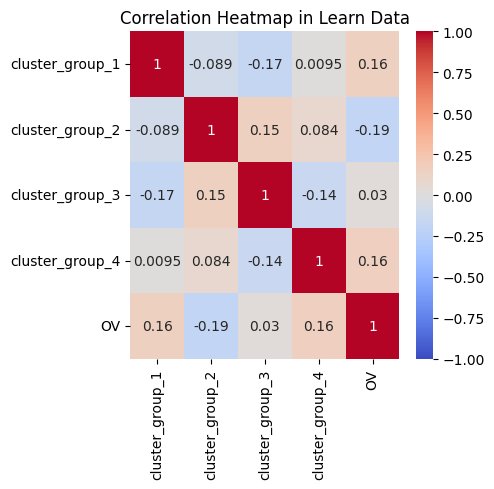

In [4]:
corr = cluser_ov.corr()

plt.figure(figsize=(5,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap in Learn Data')
plt.tight_layout()
plt.savefig('../docs/output/learn相関ヒートマップ.png')
plt.show()

## ここまでの思考
- `group3`と`OV`の相関は0.03であり、削除して良き。
- `group1,2,4`で、`OV`に対して影響を与える4変数を抜粋-> 可視化

In [5]:
learn_X = pd.read_csv("../data/interim/learn_X.csv")
test_X = pd.read_csv("../data/interim/test_X.csv")
learn_y = pd.read_csv("../data/interim/learn_y.csv")
test_y = pd.read_csv("../data/interim/test_y.csv")

def remove_time_series_data(df):
    df.drop(columns=["process_end_time", "final_mes_time"], inplace=True)
    return df

learn_X = remove_time_series_data(learn_X)
test_X = remove_time_series_data(test_X)



In [6]:
not_use = [f"X{i}" for i in range(43, 64)]
not_use.append("X23")

# not_use に含まれない列だけ残す（= 不要列を落とす）
use_cols = [col for col in learn_X.columns if col not in not_use]
new_learn_X = learn_X[use_cols]

new_learn_X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,22.45,9.40,803.80,0.68,0.15,0.08,56.11,5.27,33.98,0.96,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
2,22.03,1.14,594.52,0.64,0.14,0.08,51.57,6.15,10.44,0.94,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
3,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
4,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [7]:
df_ = pd.concat([new_learn_X, learn_y], axis=1)
df_.head()






,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,OV
0,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,111.2886
1,22.45,9.40,803.80,0.68,0.15,0.08,56.11,5.27,33.98,0.96,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,201.5617
2,22.03,1.14,594.52,0.64,0.14,0.08,51.57,6.15,10.44,0.94,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,111.9410
3,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,182.3914
4,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,196.2703


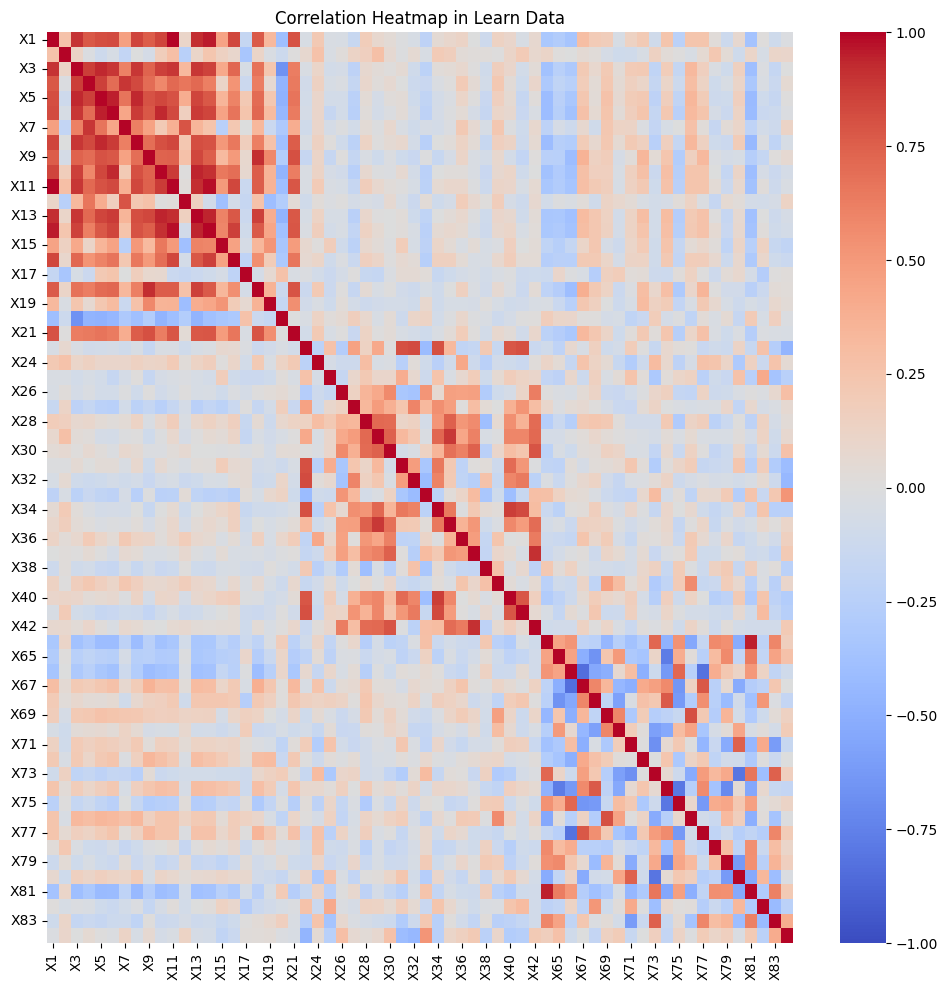

In [8]:

corr = df_.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap in Learn Data')
plt.tight_layout()
plt.savefig('../docs/output/learn相関ヒートマップ.png')
plt.show()

In [9]:
corr_ov = corr["OV"].sort_values(ascending=False)
corr_ov.head(10)


OV     1.000000
X33    0.521452
X83    0.400076
X26    0.281826
X30    0.272349
X65    0.271022
X37    0.209641
X42    0.208957
X81    0.206451
X77    0.191160
Name: OV, dtype: float64

- `X83`, `X33`にのみ注目して考える
- モデルの比較

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


import numpy as np

poly = PolynomialFeatures(degree=2, include_bias=False)

pipeline1 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline2 = Pipeline([
    ("poly", poly),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline3 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())
])

pipeline1.fit(learn_X[["X33","X83"]], learn_y)
pipeline2.fit(learn_X[["X33","X83"]], learn_y)
pipeline3.fit(learn_X[["X33","X83"]], learn_y)

pred1 = pipeline1.predict(test_X[["X33","X83"]])
pred2 = pipeline2.predict(test_X[["X33","X83"]])
pred3 = pipeline3.predict(test_X[["X33","X83"]])


rsme1 = np.sqrt(mean_squared_error(pred1, test_y))
rsme2 = np.sqrt(mean_squared_error(pred2, test_y))
rsme3 = np.sqrt(mean_squared_error(pred3, test_y))

print(f"RandomForestRegressorのRMSE: {rsme1}")
print(f"LinearRegressionのRMSE: {rsme2}")
print(f"SVRのRMSE: {rsme3}")


RandomForestRegressorのRMSE: 75.51710528343482
LinearRegressionのRMSE: 731.5117513549656
SVRのRMSE: 68.88950381692577


/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yutotakagi/Develop/ass-production-management2/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import numpy as np
more = [f"X{i}" for i in range(1,84) if i not in [33,83]]
min_rsme = 1000000

for i in more:
    # poly = PolynomialFeatures(degree=2, include_bias=False)
    for j, model in {
        "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
        "LinearRegression": LinearRegression(),
        "SVR": SVR()
    }.items():
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        pipeline.fit(learn_X[["X33","X83", i]], learn_y["OV"])
        pred = pipeline.predict(test_X[["X33","X83", i]])
        rsme = np.sqrt(mean_squared_error(pred, test_y))
        #print(f"{j}のRMSE(X33,X83,{i}): {rsme}")
        if rsme < min_rsme:
            min_rsme = rsme
            best_model = j
            best_feature = i

print(f"最良モデル: {best_model}")
print(f"最良特徴量: {best_feature}")
print(f"最良RMSE: {min_rsme}")

最良モデル: SVR
最良特徴量: X30
最良RMSE: 59.73520526823988


## 変数は、以下の3つで固定する
- X30
- X33
- X83

In [12]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())
])
pipeline.fit(learn_X[["X30","X33","X83"]], learn_y["OV"])
pred = pipeline.predict(test_X[["X30","X33","X83"]])
rsme = np.sqrt(mean_squared_error(pred, test_y))
print(f"最良RMSE: {rsme}")

最良RMSE: 59.73520526823988


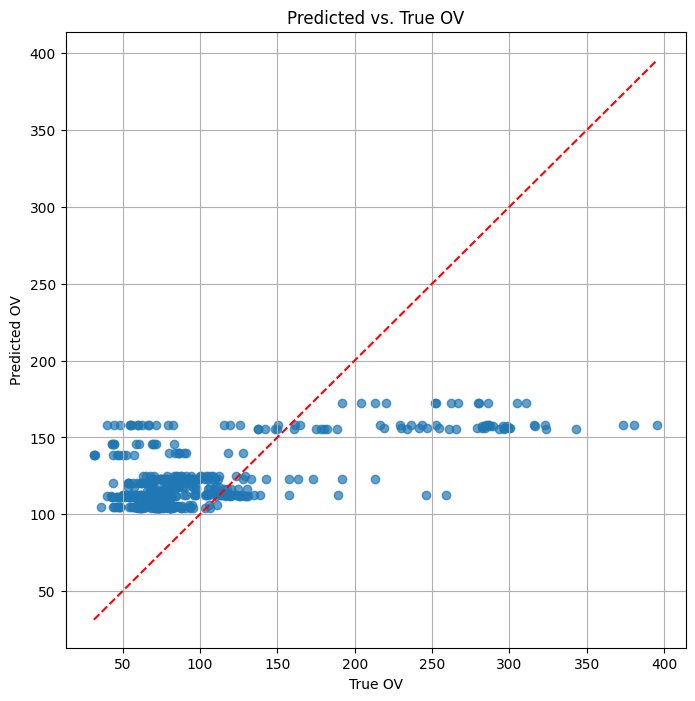

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(test_y, pred, alpha=0.7)
plt.xlabel("True OV")
plt.ylabel("Predicted OV")
plt.title("Predicted vs. True OV")
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--')
plt.grid(True)
plt.show()
